## Ideal age(@id ideal-age)

The tracer equation for the ideal age is:

$$\left(\partial_t + \mathbf{T}\right) \boldsymbol{a} = 1 - \frac{\boldsymbol{a}}{τ} \, (\boldsymbol{z} \le z_0),$$

where the sink term on the right clamps the age to $0$ at the surface (where $\boldsymbol{z} \le z_0$).
The smaller the timescale $\tau$, the quicker $\boldsymbol{a}$ is restored to $0$ at the surface.

AIBECS can interpret tracer equations as long as you arrange them under the generic form:

$$\big(\partial_t + \mathbf{T}(\boldsymbol{p}) \big) \boldsymbol{x} = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}),$$

where $\mathbf{T}(\boldsymbol{p})$ is the transport, $\boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p})$ is the net local sources and sinks, and $\boldsymbol{p}$ is the vector of model parameters.
We will then use the AIBECS to simulate the ideal age by finding the steady-state of the system, i.e., the solution of

$$\partial_t \boldsymbol{x} = \boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}) - \mathbf{T}(\boldsymbol{p}) \, \boldsymbol{x} = 0.$$

In this tutorial, we will simulate the ideal age by
1. defining functions for `T(p)` and `G(x,p)`,
1. defining the parameters `p`,
1. generating the state function `F(x,p)` and solving the associated steady-state problem,
1. and finally making a plot of our simulated ideal age.

We start by telling Julia that we want to use the AIBECS package and the OCIM2 circulation
(the Ocean Circulation Inverse Model, see [1](https://doi.org/10.1029/2018JC014716) for details).
(the Ocean Circulation Inverse Model[^1]).

[^1]:
    DeVries, T., & Holzer, M. (2019). Radiocarbon and helium isotope constraints on deep ocean ventilation and mantle‐³He sources. Journal of Geophysical Research: Oceans, 124, 3036–3057. doi:[10.1029/2018JC014716](https://doi.org/10.1029/2018JC014716)


In [2]:
using AIBECS
grd, T_OCCA = OCCA.load()
sum(iswet(grd))

┌ Info: Precompiling AIBECS [ace601d6-714c-11e9-04e5-89b7fad23838]
└ @ Base loading.jl:1260
┌ Info: You are about to use the OCCA model.
│ If you use it for research, please cite:
│ 
│ - Forget, G., 2010: Mapping Ocean Observations in a Dynamical Framework: A 2004–06 Ocean Atlas. J. Phys. Oceanogr., 40, 1201–1221, https://doi.org/10.1175/2009JPO4043.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "Forget_2010" key.)
└ @ AIBECS.OCCA /Users/jml1/Dropbox (MIT)/Applications/Julia/AIBECS.jl/src/OCCA.jl:84


84661

**Note**
If it's your first time, Julia will ask you to download the OCIM2, in which case you should accept (i.e., type `y` and "return").
Once downloaded, AIBECS will remember where it downloaded the file and it will only load it from your laptop.

# `grd` is an `OceanGrid` object containing information about the 3D grid of the OCIM2 circulation and `T_OCCA` is the transport matrix representing advection and diffusion.

# We define the function `T(p)` as

In [3]:
T(p) = T_OCCA

T (generic function with 1 method)

## (It turns out the circulation `T(p)` does not effectively depend on `p` but that's how we must define it anyway, i.e., as a function of `p`.)

# The local sources and sinks for the age take the form

In [4]:
function G(x,p)
    @unpack τ, z₀ = p
    return @. 1 - x / τ * (z ≤ z₀)
end

G (generic function with 1 method)

## as per the tracer equation.
## The `@unpack` line unpacks the parameters `τ` and `z₀`.
## The `return` line returns the net sources and sinks.
## (The `@.` "macro" tells Julia that the operations apply to every element.)

## We can define the vector `z` of depths with `depthvec`.

In [5]:
z = depthvec(grd)

84661-element Array{Float64,1}:
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
    ⋮
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25

## Now we must construct a type for `p` the parameters.
## This type must contain our parameters `τ` and `z₀`.

In [6]:
struct IdealAgeParameters{U} <: AbstractParameters{U}
    τ::U
    z₀::U
end

## The type is now ready for us to generate an instance of the parameter `p`.
## Let's use `τ = 1.0` (s) and `z₀` the minimum depth of the model.

In [7]:
p = IdealAgeParameters(1.0, 30.0)


│ Row │ Symbol │ Value   │
│     │ Symbol │ Float64 │
├─────┼────────┼─────────┤
│ 1   │ τ      │ 1.0     │
│ 2   │ z₀     │ 30.0    │

IdealAgeParameters{Float64}

## We now use the AIBECS to generate the state function $\boldsymbol{F}$ (and its Jacobian) via

In [8]:
F, ∇ₓF = state_function_and_Jacobian(T, G)

(AIBECS.var"#F#97"{typeof(T),typeof(G)}(T, G), AIBECS.var"#∇ₓF#99"{typeof(T),AIBECS.var"#∇ₓG#98"{typeof(G)}}(T, AIBECS.var"#∇ₓG#98"{typeof(G)}(G)))

# (`∇ₓF` is the **Jacobian** of the state function $\nabla_{\boldsymbol{x}}\boldsymbol{F}$, calculated automatically using dual numbers.)

## Now that `F(x,p)`, and `p` are defined, we are going to solve for the steady-state.
## But first, we must create a `SteadyStateProblem` object that contains `F`, `∇ₓF`, `p`, and an initial guess `x_init` for the age.
## (`SteadyStateProblem` is specialized from [DiffEqBase](https://github.com/JuliaDiffEq/DiffEqBase.jl) for AIBECS models.)

## Let's make a vector of 0's for our initial guess.

In [9]:
nb = sum(iswet(grd))  # number of wet boxes
x_init = zeros(nb)    # Start with age = 0 everywhere

84661-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Now we can create our `SteadyStateProblem` instance

In [10]:
prob = SteadyStateProblem(F, ∇ₓF, x_init, p)

SteadyStateProblem with uType Array{Float64,1}
u0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## And finally, we can `solve` this problem, using the AIBECS `CTKAlg()` algorithm,

In [11]:
age = solve(prob, CTKAlg())

u: 84661-element Array{Float64,1}:
    7.331234907758129
   49.68400493239786
 5506.777550993458
  190.85777854992799
  139.13972925140783
  123.97376829178809
  149.7693782345731
  274.3726564783382
  255.36858631634686
  134.43964979234238
   47.80118605076457
    2.709557546969844
   13.266194170647243
    ⋮
    1.4761695270246597e10
    1.4436901161690928e10
    1.4314224095249483e10
    1.4260718858907816e10
    1.4279719492644833e10
    1.433570359401319e10
    1.4273341002055992e10
    1.4022309421443502e10
    1.3743007803606102e10
    1.3382673931035572e10
    1.3274870803938221e10
    1.3177864373683771e10

## This should take a few seconds.

# To conclude this tutorial, let's have a look at the age using AIBECS' plotting recipes and [Plots.jl](https://github.com/JuliaPlots/Plots.jl).

In [12]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


## We first convert the age in years
## (because the default SI unit we used, i.e., seconds, is a bit small relative to global ocean timescales).

In [13]:
age_in_yrs = age * u"s" .|> u"yr"

84661-element Array{Quantity{Float64,𝐓,Unitful.FreeUnits{(yr,),𝐓,nothing}},1}:
  2.3231281554231402e-7 yr
  1.5743911112504708e-6 yr
 0.00017449925060820397 yr
  6.0479180466806085e-6 yr
   4.409071958938823e-6 yr
   3.928491656266259e-6 yr
   4.745905209349668e-6 yr
   8.694344832253979e-6 yr
    8.09214218813683e-6 yr
   4.260135428307044e-6 yr
  1.5147281811913633e-6 yr
   8.586069748554528e-8 yr
  4.2038032583742873e-7 yr
                         ⋮
     467.76989600750994 yr
     457.47779177411866 yr
      453.5903901199547 yr
     451.89491149224955 yr
     452.49700524263034 yr
     454.27103436298034 yr
      452.2948830727302 yr
     444.34017230218717 yr
     435.48963810955524 yr
      424.0713467131712 yr
      420.6552717550834 yr
     417.58132347465494 yr

## And we take a horizontal slice at about 2000m.

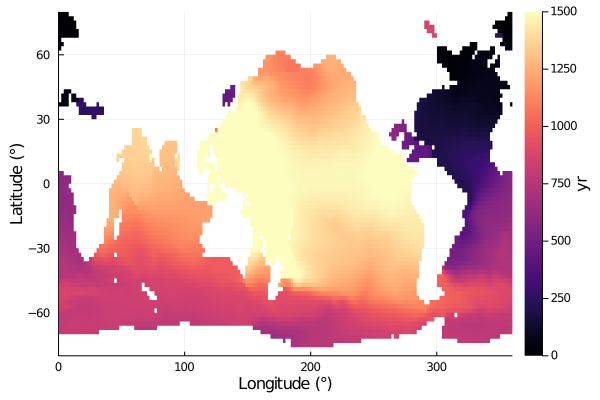

In [16]:
plothorizontalslice(age_in_yrs, grd, depth=2000u"m", color=:magma, levels=range(0.0, 1500, length = 16), clim=(0.0,1500))

## Or look at the horiontal mean

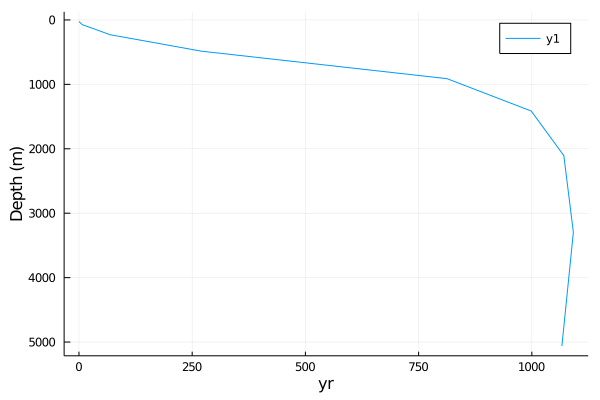

In [15]:
plothorizontalmean(age_in_yrs, grd)

## That's it for this tutorial...
# Good job!